# Autoencoder

## Encoder and decoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        latent_space = self.encoder(x)
        reconstructed = self.decoder(latent_space)
        reconstructed = reconstructed.view(x.size(0), 1, 28, 28)
        return latent_space, reconstructed



## Load MNIST dataset

In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),


])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 444kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.99MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.67MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Using cpu device


## Training the model

In [8]:

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)

        _, reconstructed = model(x)

        loss = criterion(reconstructed, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0489
Epoch [2/20], Loss: 0.0271
Epoch [3/20], Loss: 0.0222
Epoch [4/20], Loss: 0.0196
Epoch [5/20], Loss: 0.0178
Epoch [6/20], Loss: 0.0163
Epoch [7/20], Loss: 0.0153
Epoch [8/20], Loss: 0.0143
Epoch [9/20], Loss: 0.0136
Epoch [10/20], Loss: 0.0129
Epoch [11/20], Loss: 0.0123
Epoch [12/20], Loss: 0.0119
Epoch [13/20], Loss: 0.0115
Epoch [14/20], Loss: 0.0111
Epoch [15/20], Loss: 0.0109
Epoch [16/20], Loss: 0.0106
Epoch [17/20], Loss: 0.0104
Epoch [18/20], Loss: 0.0103
Epoch [19/20], Loss: 0.0101
Epoch [20/20], Loss: 0.0099


## Save latnent space for test data

In [9]:
import numpy as np

model.eval()

encoded_data = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        latent_space, _ = model(x)
        encoded_data.append(latent_space.cpu().numpy())
        labels.append(y.numpy())

encoded_data = np.concatenate(encoded_data, axis=0)
labels = np.concatenate(labels, axis=0)

print(f"Encoded data shape: {encoded_data.shape}")
print(f"Labels shape: {labels.shape}")

np.save("encoded_data.npy", encoded_data)
np.save("labels.npy", labels)

Encoded data shape: (10000, 16)
Labels shape: (10000,)


## Isomap for Encrypt data

Shape of 2D data: (10000, 2)


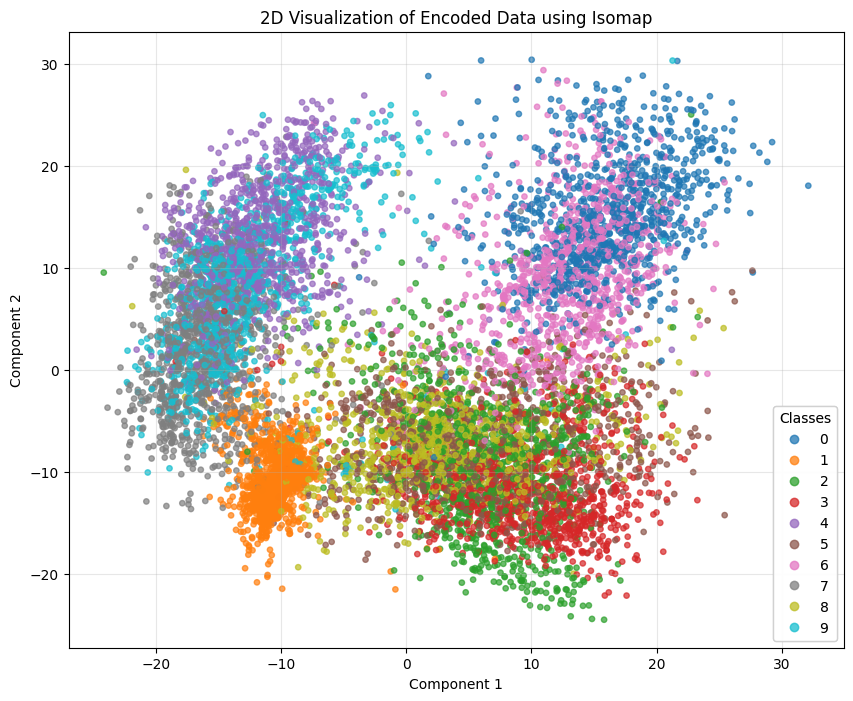

In [10]:
import numpy as np
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

encoded_data = np.load("encoded_data.npy")
labels = np.load("labels.npy")

isomap = Isomap(n_components=2)
data_2d = isomap.fit_transform(encoded_data)

print(f"Shape of 2D data: {data_2d.shape}")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap="tab10", s=15, alpha=0.7)
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend)
plt.title("2D Visualization of Encoded Data using Isomap")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(alpha=0.3)
plt.show()


## Isomap on raw MNIST data

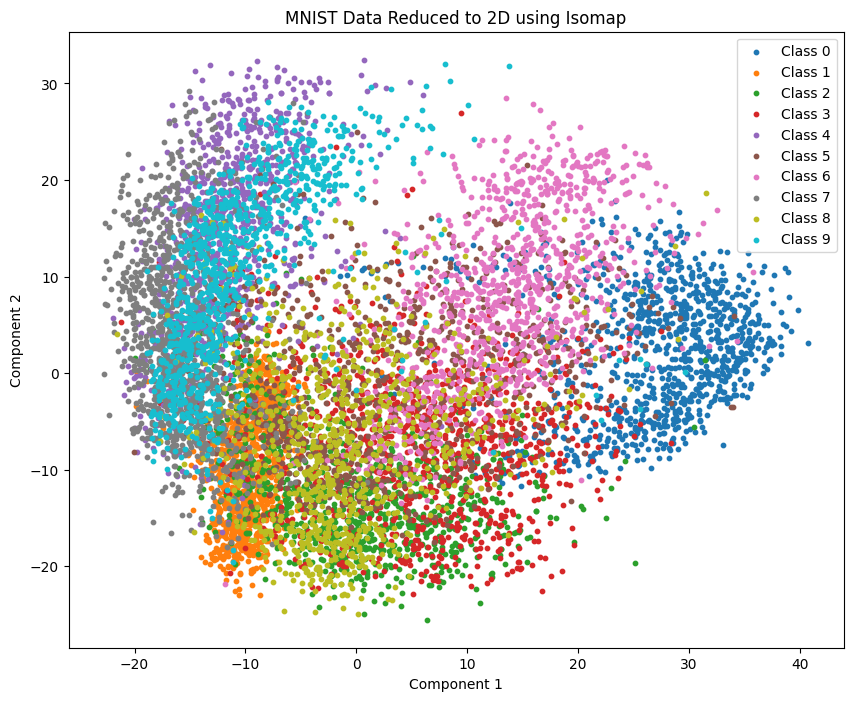

In [11]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap

transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=10000, shuffle=False)

data_iter = iter(data_loader)
images, labels = next(data_iter)

images_flattened = images.view(images.shape[0], -1).numpy()
labels = labels.numpy()

isomap = Isomap(n_components=2)
data_2d = isomap.fit_transform(images_flattened)

plt.figure(figsize=(10, 8))
for i in range(10):
    idx = labels == i
    plt.scatter(data_2d[idx, 0], data_2d[idx, 1], label=f"Class {i}", s=10)

plt.title("MNIST Data Reduced to 2D using Isomap")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


## Classification model for latent space

### Save latent space for train data

In [12]:
import numpy as np
import torch

model.eval()

encoded_train_data = []
train_labels = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        latent_space, _ = model(x)
        encoded_train_data.append(latent_space.cpu().numpy())
        train_labels.append(y.numpy())

encoded_train_data = np.concatenate(encoded_train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print(f"Encoded train data shape: {encoded_train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")

np.save("encoded_train_data.npy", encoded_train_data)
np.save("train_labels.npy", train_labels)

Encoded train data shape: (60000, 16)
Train labels shape: (60000,)


### create dataset

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

encoded_testdata = np.load("encoded_data.npy")
labels_test = np.load("labels.npy")
encoded_train_data= np.load("encoded_train_data.npy")
train_labels = np.load("train_labels.npy")

latent_train_data_tensor = torch.tensor(encoded_train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

latent_test_data_tensor = torch.tensor(encoded_testdata, dtype=torch.float32)
test_labels_tensor = torch.tensor(labels_test, dtype=torch.long)

train_dataset = TensorDataset(latent_train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(latent_test_data_tensor, test_labels_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)



### classifiction model

In [14]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(x)

input_size = latent_train_data_tensor.shape[1]
num_classes = 10
classifier = Classifier(input_size, num_classes)

print(classifier)

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


### train the model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

train_model(classifier, train_dataloader, criterion, optimizer)


Epoch [1/50], Loss: 1.7259
Epoch [2/50], Loss: 1.5575
Epoch [3/50], Loss: 1.5432
Epoch [4/50], Loss: 1.5358
Epoch [5/50], Loss: 1.5309
Epoch [6/50], Loss: 1.5271
Epoch [7/50], Loss: 1.5239
Epoch [8/50], Loss: 1.5215
Epoch [9/50], Loss: 1.5193
Epoch [10/50], Loss: 1.5174
Epoch [11/50], Loss: 1.5157
Epoch [12/50], Loss: 1.5144
Epoch [13/50], Loss: 1.5134
Epoch [14/50], Loss: 1.5121
Epoch [15/50], Loss: 1.5109
Epoch [16/50], Loss: 1.5102
Epoch [17/50], Loss: 1.5091
Epoch [18/50], Loss: 1.5083
Epoch [19/50], Loss: 1.5075
Epoch [20/50], Loss: 1.5067
Epoch [21/50], Loss: 1.5058
Epoch [22/50], Loss: 1.5052
Epoch [23/50], Loss: 1.5045
Epoch [24/50], Loss: 1.5039
Epoch [25/50], Loss: 1.5033
Epoch [26/50], Loss: 1.5027
Epoch [27/50], Loss: 1.5022
Epoch [28/50], Loss: 1.5019
Epoch [29/50], Loss: 1.5012
Epoch [30/50], Loss: 1.5011
Epoch [31/50], Loss: 1.5005
Epoch [32/50], Loss: 1.5004
Epoch [33/50], Loss: 1.4999
Epoch [34/50], Loss: 1.4993
Epoch [35/50], Loss: 1.4993
Epoch [36/50], Loss: 1.4988
E

### Classification report and confusion matrix

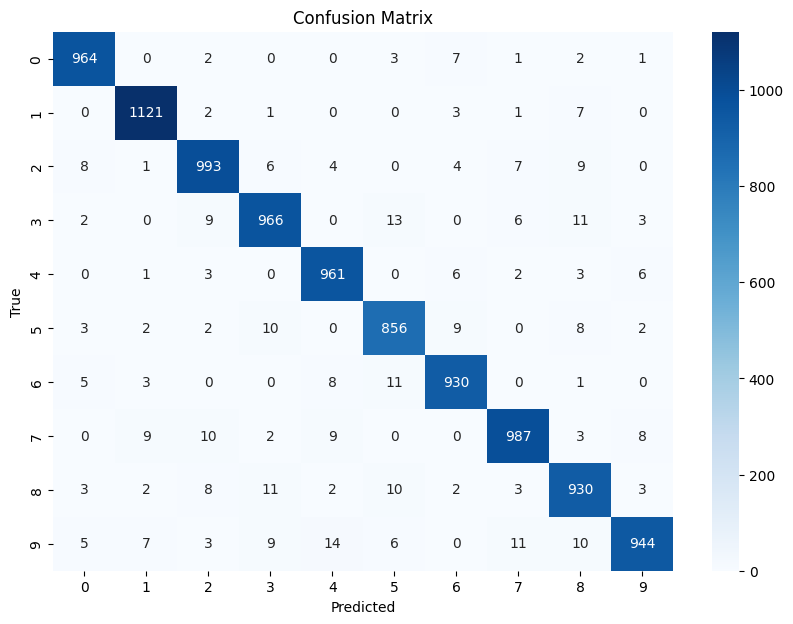

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.98      0.97       982
           5       0.95      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_with_report(model, dataloader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:


            outputs = model(x_batch)

            _, predicted = torch.max(outputs, 1)

            all_labels.extend(y_batch.numpy())
            all_preds.extend(predicted.numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)])
    print("Classification Report:\n", report)

evaluate_model_with_report(classifier, test_dataloader, num_classes=10)
